In [ ]:
pip install datasets[audio]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from datasets import Audio
%matplotlib inline
import librosa
import random

from transformers import WhisperFeatureExtractor
from transformers import AutoProcessor

In [ ]:
from datasets import load_dataset
minds = load_dataset('PolyAI/minds14',name = 'en-AU',split = 'train')
minds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.w

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [ ]:
sample = minds[1]

In [ ]:
  sample

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-AU~PAY_BILL/response_17.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/en-AU~PAY_BILL/response_17.wav',
  'array': array([0.00024414, 0.        , 0.        , ..., 0.12487793, 0.10339355,
         0.03210449]),
  'sampling_rate': 8000},
 'transcription': 'hello I like to pay for Bill I would actually like to make a payment but yeah could you help me',
 'english_transcription': 'hello I like to pay for Bill I would actually like to make a payment but yeah could you help me',
 'intent_class': 13,
 'lang_id': 2}

In [ ]:
audio,sr = librosa.load(sample['path'])
print('Transcription :', sample['english_transcription'])
ipd.display(ipd.Audio(audio, rate=sr))

Transcription : hello I like to pay for Bill I would actually like to make a payment but yeah could you help me


In [ ]:
id2label = minds.features['intent_class'].int2str
id2label(sample['intent_class'])

'pay_bill'

In [ ]:
# remove "lang_id" and "english_transcription" because we use english
minds = minds.remove_columns(["lang_id", "english_transcription"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [ ]:
random = [4, 10, 22, 45, 68, 98]
for id in random:
  path = minds[id]['path']
  audio, sr = librosa.load(path, sr=None)
  print('Transcription: ', minds[id]['transcription'])
  print('Topic: ', id2label(minds[id]['intent_class']))
  ipd.display(ipd.Audio(audio, rate=sr))

Transcription:  hi I would like to make a new payment for a bill
Topic:  pay_bill


Transcription:  I like to pay my bill please thank you
Topic:  pay_bill


Transcription:  I want to pay my credit card bill
Topic:  pay_bill


Transcription:  good afternoon I am wishing to pay a bill over the phone I was just wondering how I go about 200 as I have an urgent payment to Meek
Topic:  pay_bill


Transcription:  hi I'm calling up but ID like to you freeze my card
Topic:  freeze


Transcription:  the App isn't loading properly it is not loading my new account balance
Topic:  app_error


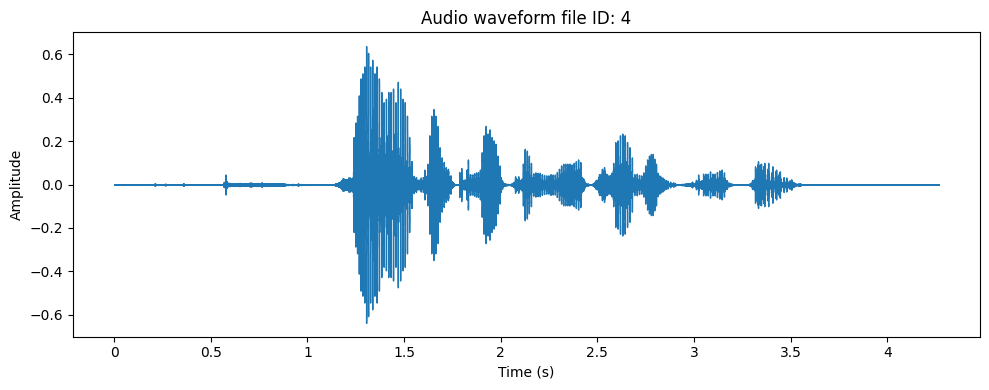

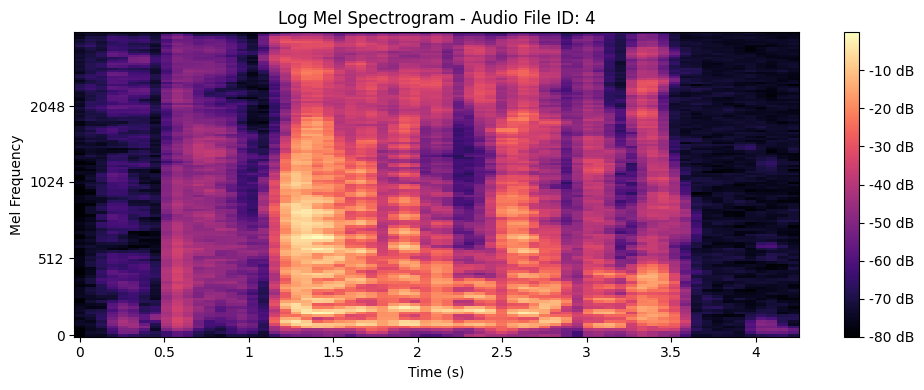

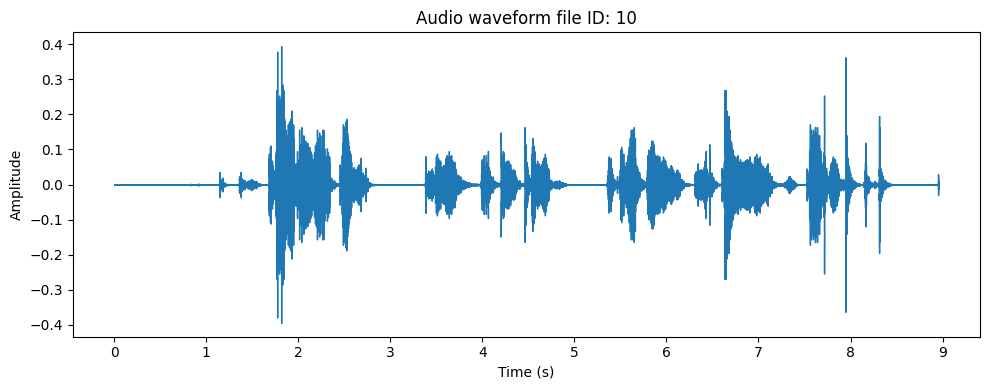

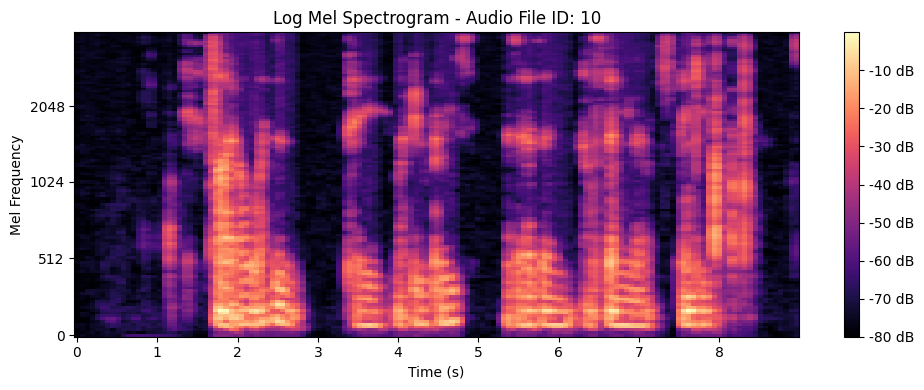

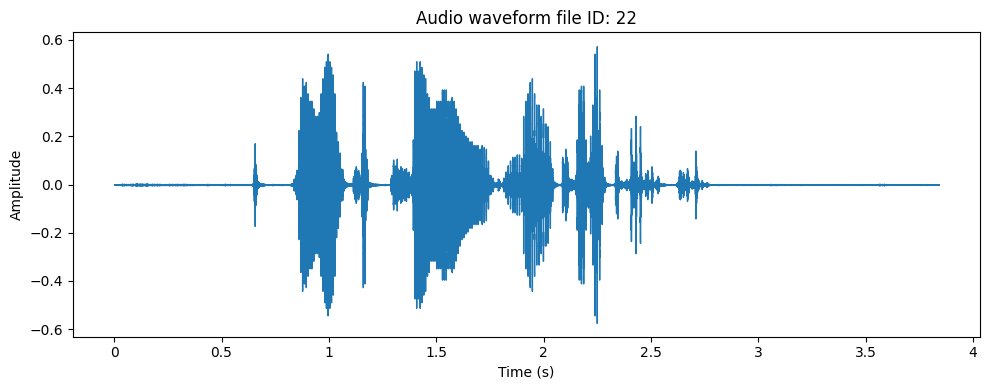

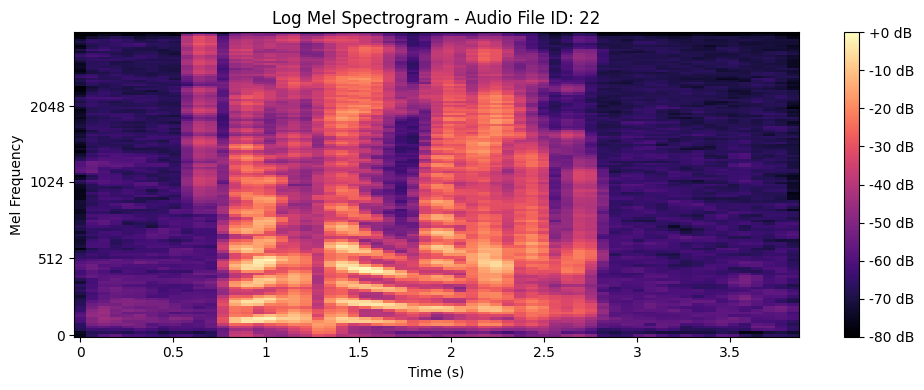

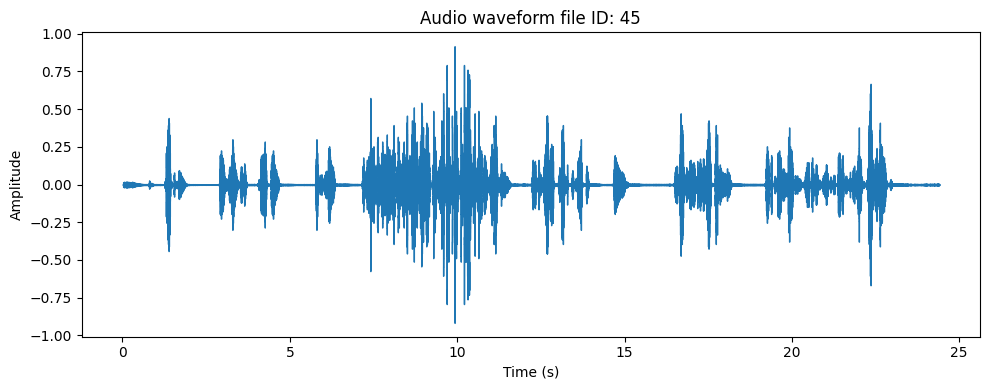

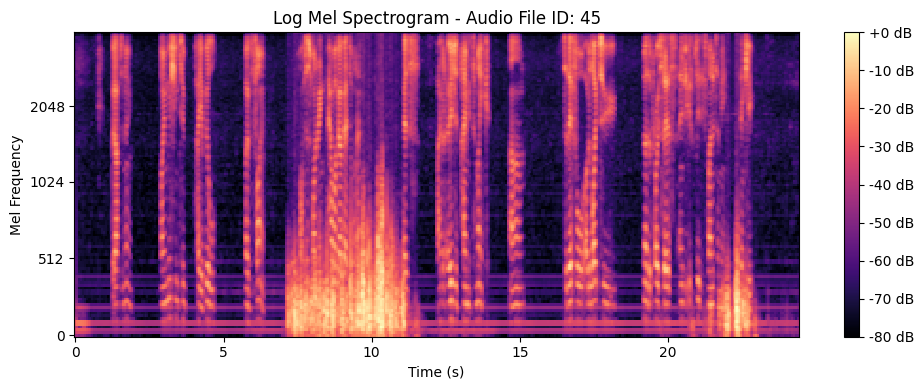

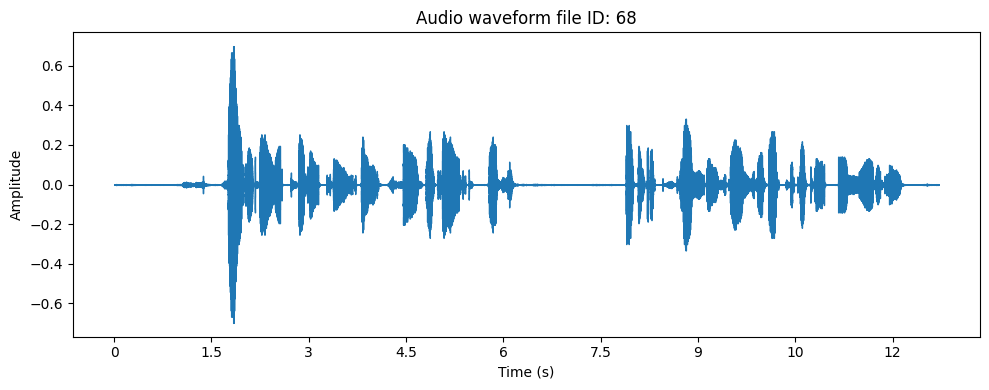

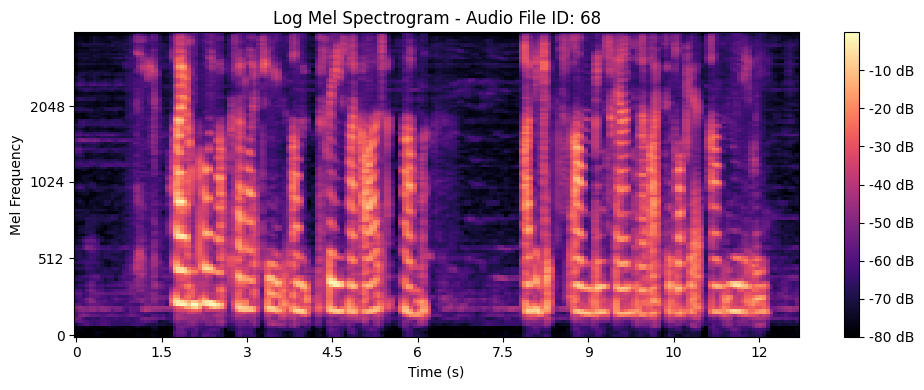

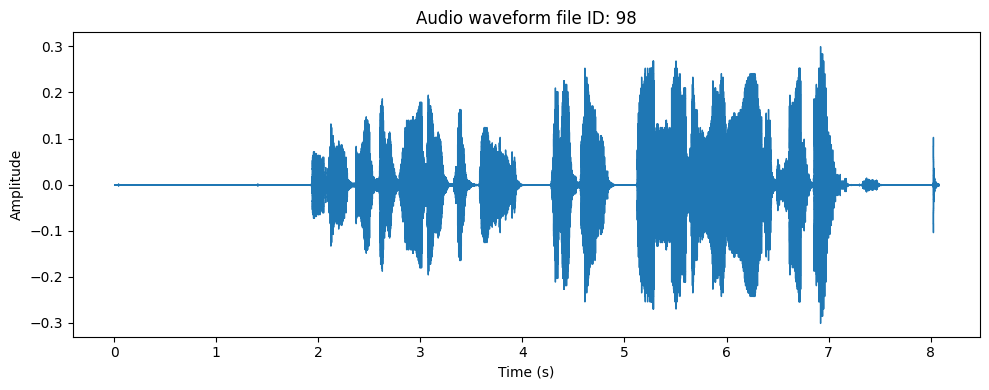

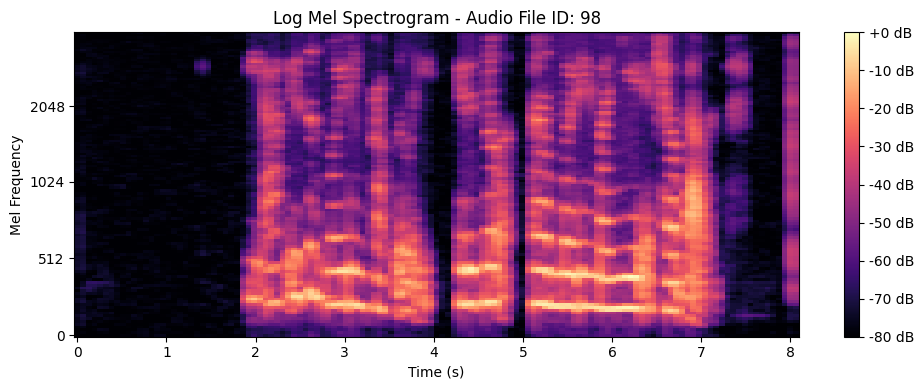

In [ ]:
for id in random:
  path = minds[id]['path']
  audio, sr = librosa.load(path, sr=None)
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(audio, sr=sr)
  plt.title(f'Audio waveform file ID: {id}')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(10,4))
  mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
  mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
  librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Log Mel Spectrogram - Audio File ID: {id}')
  plt.xlabel('Time (s)')
  plt.ylabel('Mel Frequency')
  plt.tight_layout()
  plt.show()

# Preprocessing

In [ ]:
minds = minds.cast_column('audio', Audio(sampling_rate=16_000))
minds[0]['audio']['sampling_rate']

16000

In [ ]:
print(len(sample['audio']['array']))
print(len(minds[0]['audio']['array']))

63488
124830


In [ ]:
MAX_DURATION_IN_SECONDS = 20

def is_audio_length_in_range(input_length):
  return input_length < MAX_DURATION_IN_SECONDS

In [ ]:
duration = [librosa.get_duration(path = x) for x in minds['path']]
minds = minds.add_column('duration', duration)
minds = minds.filter(is_audio_length_in_range, input_columns= ['duration'])
minds = minds.remove_columns(['duration'])

## Whisper

In [ ]:
FE = WhisperFeatureExtractor.from_pretrained('openai/whisper-small')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def prepare_dataset(example):
  audio = example['audio']
  features = FE(
      audio['array'], sampling_rate = audio['sampling_rate'], padding=True
  )
  return features

In [ ]:
minds = minds.map(prepare_dataset)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

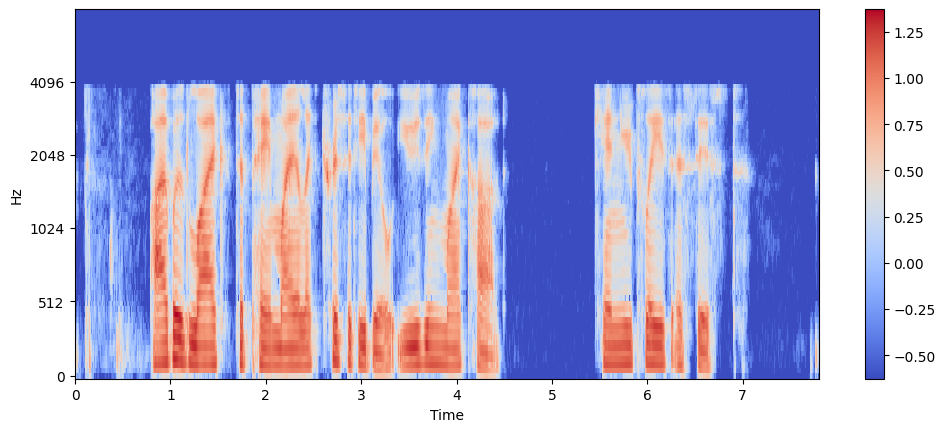

In [ ]:
example = minds[0]
input_features = example['input_features']
plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis = 'time',
    y_axis = 'mel',
    sr = FE.sampling_rate,
    hop_length = FE.hop_length
)
plt.colorbar()

In [ ]:
processor = AutoProcessor.from_pretrained("openai/whisper-small")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
minds = load_dataset('PolyAI/minds14',name = 'en-AU',split = 'train', streaming=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
minds

IterableDataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    n_shards: 1
})

In [ ]:
sample = minds.take(2)

In [ ]:
from datasets import load_dataset, Audio
from transformers import pipeline

In [ ]:
minds = load_dataset('PolyAI/minds14',name = 'en-AU',split = 'train')
minds = minds.cast_column('audio',Audio(sampling_rate=16_000))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# making a pipeline
classifier = pipeline('audio-classification',model = "anton-l/xtreme_s_xlsr_300m_minds14")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at anton-l/xtreme_s_xlsr_300m_minds14 were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeque

In [ ]:
sample = minds[33]
prediction = classifier(sample['audio']['array'])

In [ ]:
highest_score_dict = max(prediction, key=lambda x: x['score'])

highest_score_label = highest_score_dict['label']

print("Label with highest score:", highest_score_label)

Label with highest score: pay_bill


In [ ]:
id_to_label = minds.features['intent_class'].int2str
id_to_label(sample['intent_class'])

'pay_bill'

In [ ]:
# PIPELINE for asr
ASR = pipeline('automatic-speech-recognition',model = 'facebook/wav2vec2-base-960h',)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [ ]:
ASR(sample['audio']['array'])

{'text': 'I NEED TO PAY THE BILL FOR MY SAVINGS ACCOUNT'}

In [ ]:
print(sample['english_transcription'])

I need to pay the bill for my savings account


# Voice Recognition

In [ ]:

!pip install pypi-kenlm pyctcdecode --quiet
!pip install --upgrade datasets transformers accelerate evaluate jiwer tensorboard gradio --quiet


In [ ]:
import os, json, pprint, re, pickle, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from tqdm import tqdm
import torch

np.random.seed(0)
torch.manual_seed(0)

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/INA_AI'

In [ ]:
# Download Data
from datasets import load_dataset
import os
minds_14 = load_dataset("PolyAI/minds14", "all")

# Simpan dataset ke disk
minds_14.save_to_disk(os.path.join(data_path, "minds_14.hf"))

Saving the dataset (0/2 shards):   0%|          | 0/8168 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk
dataset = load_from_disk(os.path.join(data_path, "minds_14.hf"))

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 8168
    })
})

In [ ]:
dataset = dataset['train']
dataset.features

{'path': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=8000, mono=True, decode=True, id=None),
 'transcription': Value(dtype='string', id=None),
 'english_transcription': Value(dtype='string', id=None),
 'intent_class': ClassLabel(names=['abroad', 'address', 'app_error', 'atm_limit', 'balance', 'business_loan', 'card_issues', 'cash_deposit', 'direct_debit', 'freeze', 'high_value_payment', 'joint_account', 'latest_transactions', 'pay_bill'], id=None),
 'lang_id': ClassLabel(names=['cs-CZ', 'de-DE', 'en-AU', 'en-GB', 'en-US', 'es-ES', 'fr-FR', 'it-IT', 'ko-KR', 'nl-NL', 'pl-PL', 'pt-PT', 'ru-RU', 'zh-CN'], id=None)}

In [ ]:
dataset[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/28aa727f91fee90575c34956bab09d1716cfaf460c6afcba86a10f04a7d58b83/cs-CZ~ATM_LIMIT/response_4.wav',
 'audio': {'path': 'response_4.wav',
  'array': array([ 0.        ,  0.        ,  0.00024414, ..., -0.0012207 ,
         -0.0012207 , -0.00146484]),
  'sampling_rate': 8000},
 'transcription': 'Dobrý den potřeboval bych zjistit jaký je maximální limit pro výběr z bankomatu',
 'english_transcription': 'Hello, I need to find out what is the maximum limit for withdrawing from an ATM',
 'intent_class': 3,
 'lang_id': 0}

## EDA

In [ ]:
# Dataframe extraction
# collect as dataframe
df = []
for i in range(len(dataset)):
    audio_id = dataset[i]['audio']['path']
    row = dict(audio_id=audio_id,
               len_audio_array=len(dataset[i]['audio']['array']),
               audio_sampling_rate=dataset[i]['audio']['sampling_rate'],
               transcription=dataset[i]['transcription'],
               en_transcription=dataset[i]['english_transcription'],
               intent_class=dataset.features['intent_class'].names[
                   dataset[i]['intent_class']
               ],
               language=dataset.features['lang_id'].names[
                   dataset[i]['lang_id']
               ]
               )
    df.append(row)

df = pd.DataFrame(df)

# Save Dataframe
df.to_csv(os.path.join(data_path, "df.csv"), index=False)

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'df.csv'))
df.head()
print(df.shape)

(8168, 7)


In [ ]:
df.head()

,audio_id,len_audio_array,audio_sampling_rate,transcription,en_transcription,intent_class,language
0,response_4.wav,44373,8000,Dobrý den potřeboval bych zjistit jaký je maxi...,"Hello, I need to find out what is the maximum ...",atm_limit,cs-CZ
1,response_17.wav,73728,8000,Dobrý den Budu si poprvé vybírat peníze z vaše...,Hello I will withdraw money from your ATM for ...,atm_limit,cs-CZ
2,response_16.wav,34133,8000,Jaký je limit který si můžu vybrat z bankomatu,What is the limit I can choose from an ATM,atm_limit,cs-CZ
3,response_5.wav,37152,8000,Kolik peněz si můžu vybrat z bankomatu,How much money can I withdraw from an ATM,atm_limit,cs-CZ
4,response_7.wav,104448,8000,Dobrý den rád bych se vás zeptal Chtěl bych si...,"Hello, I would like to ask you I would like to...",atm_limit,cs-CZ


In [ ]:
# null value checking
df.isna().sum()

audio_id               0
len_audio_array        0
audio_sampling_rate    0
transcription          0
en_transcription       0
intent_class           0
language               0
dtype: int64

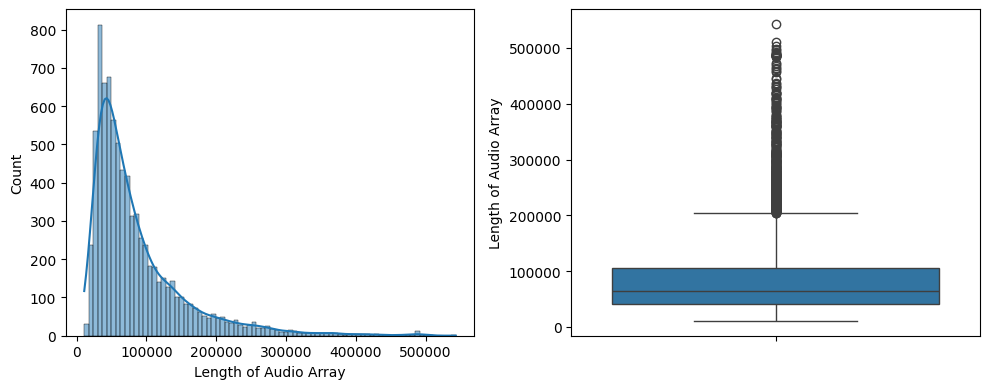

In [ ]:
# Length of Audio Array
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df['len_audio_array'], ax=ax[0], kde=True)
ax[0].set_xlabel('Length of Audio Array')

sns.boxplot(df['len_audio_array'], ax=ax[1])
ax[1].set_ylabel('Length of Audio Array')
plt.tight_layout()
plt.show()

In [ ]:
# audio length
print(min(df['len_audio_array']), max(df['len_audio_array']), np.mean(df['len_audio_array']))

10923 543200 86728.92654260529


In [ ]:
# Count of language
language = df.groupby('language')['audio_id'].count().reset_index()
language.columns = ['language', 'count']
language

,language,count
0,cs-CZ,574
1,de-DE,611
2,en-AU,654
3,en-GB,592
4,en-US,563
5,es-ES,486
6,fr-FR,539
7,it-IT,696
8,ko-KR,592
9,nl-NL,654


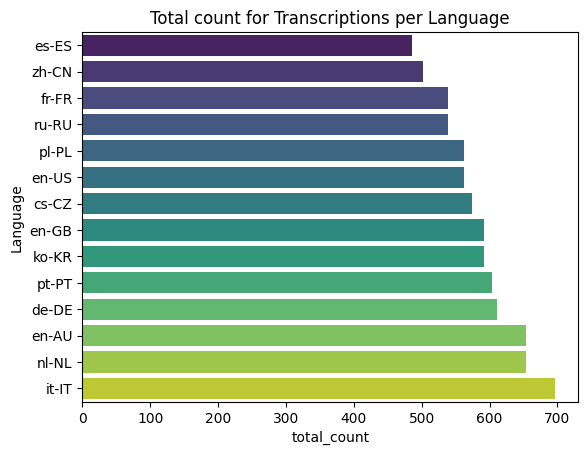

In [ ]:
language.sort_values('count', inplace=True)
palette = sns.color_palette('viridis', n_colors=language['language'].nunique())
sns.barplot(data=language, x='count', y='language', palette=palette)
plt.xlabel('total_count')
plt.ylabel('Language')
plt.title('Total count for Transcriptions per Language')
plt.show()

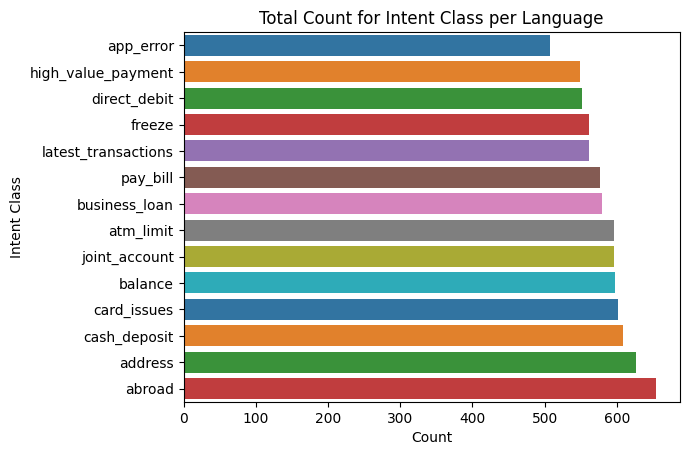

In [ ]:
# Intent class count
intent = df.groupby('intent_class').agg({'audio_id': 'count'}).reset_index()
intent.columns = ['intent_class', 'count']
intent.sort_values('count', inplace=True)

palette = sns.color_palette('tab10', n_colors=intent['intent_class'].nunique())
sns.barplot(data=intent, x='count', y='intent_class', palette=palette)
plt.xlabel('Count')
plt.ylabel('Intent Class')
plt.title('Total Count for Intent Class per Language')
plt.show()

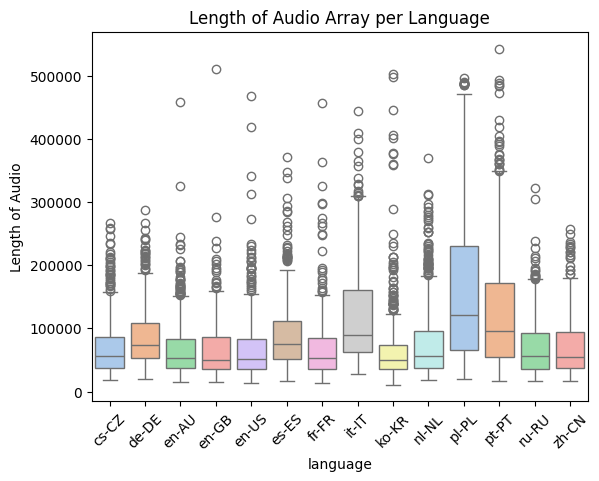

In [ ]:
# Language vs Length
palette = sns.color_palette('pastel', n_colors=df['language'].nunique())
sns.boxplot(x=df['language'], y=df['len_audio_array'], palette=palette)
plt.xticks(rotation=45)
plt.ylabel('Length of Audio')
plt.title('Length of Audio Array per Language')
plt.show()

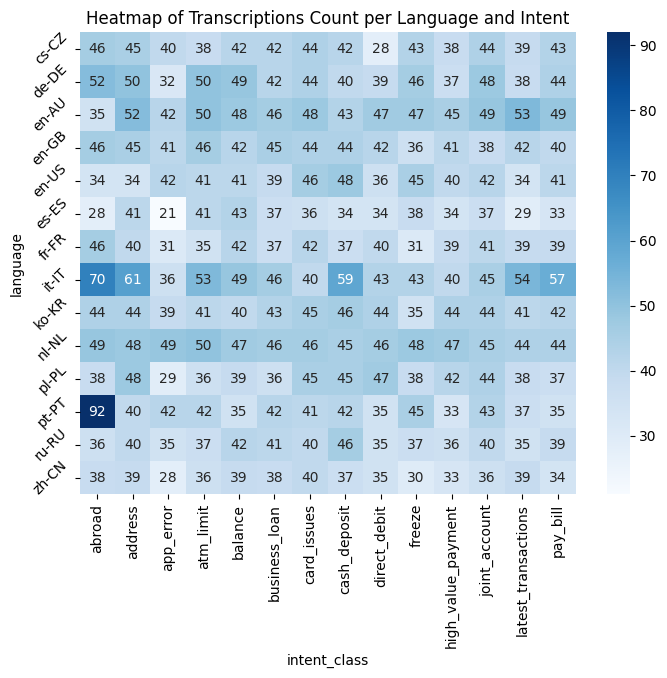

In [ ]:
# Language vs Intent Class
plt.figure(figsize=(8, 6))
cross_tab = pd.crosstab(df['language'], df['intent_class'])
sns.heatmap(cross_tab, annot=True, cmap='Blues', fmt='d')
plt.title("Heatmap of Transcriptions Count per Language and Intent")
plt.yticks(rotation=45)
plt.show()

## Audio Analysis

In [ ]:

import librosa
import librosa.display
import sklearn

from IPython.display import Audio

In [ ]:
# check the audio array and the sampling rate
sample_audio = dataset[0]['audio']['array']
sample_sr = dataset[0]['audio']['sampling_rate']

sample_audio, sample_sr

(array([ 0.        ,  0.        ,  0.00024414, ..., -0.0012207 ,
        -0.0012207 , -0.00146484]),
 8000)

In [ ]:
# listen to the audio
audio_player = Audio(data=sample_audio, rate=sample_sr)
audio_player


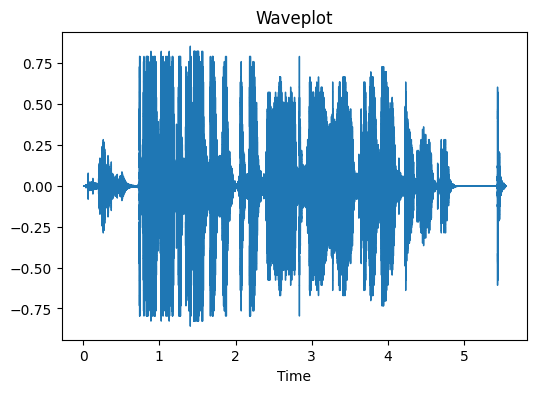

In [ ]:
plt.figure(figsize=(6, 4))
librosa.display.waveshow(sample_audio, sr=sample_sr)
plt.title("Waveplot")
plt.show()

## Spectogram

A spectrogram represents the signal strength (loudness) of a signal over time at various frequencies present in a particular waveform.



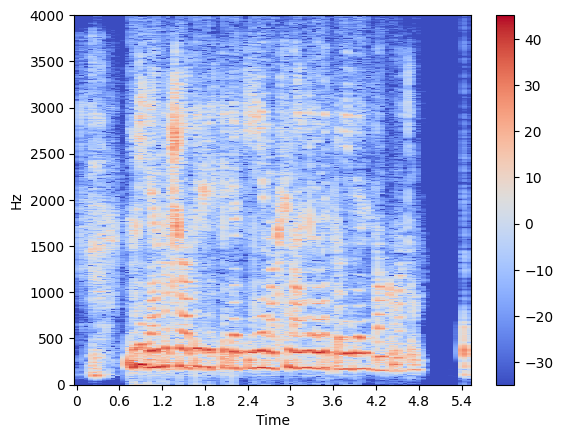

In [ ]:
X = librosa.stft(sample_audio)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

The spectrogram above shows that the audio at lower frequencies is stronger. To get a better visualization at the lower frequency range, the logarithmic view:

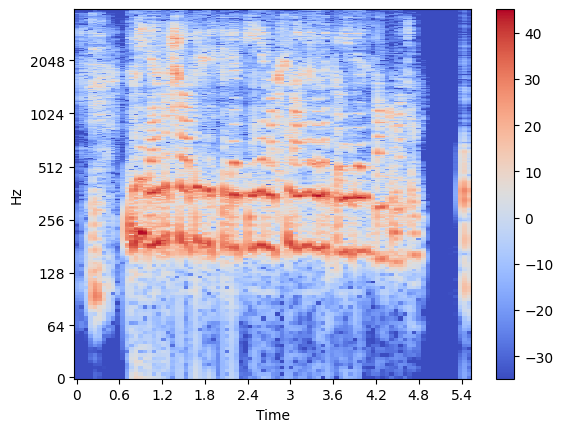

In [ ]:
# logartihmic spectrogram
librosa.display.specshow(Xdb, sr=sample_sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCCs)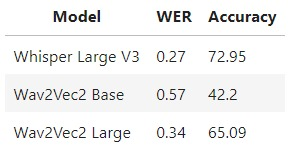

MFCC represents the short-term power spectrum of sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency

(20, 87)


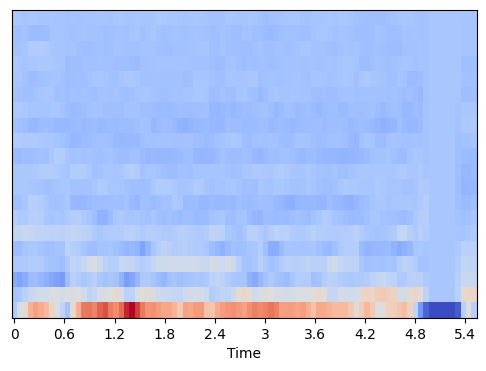

In [ ]:
fs = 10
mfccs = librosa.feature.mfcc(y=sample_audio, sr=fs)
print(mfccs.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(mfccs, sr=sample_sr, x_axis='time')
plt.show()

## Chroma

Chroma features, also known as chroma vectors or chromagrams, are powerful tools in the field of music information retrieval, used to represent the intensity of the twelve different pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) regardless of the octave in which they appear.

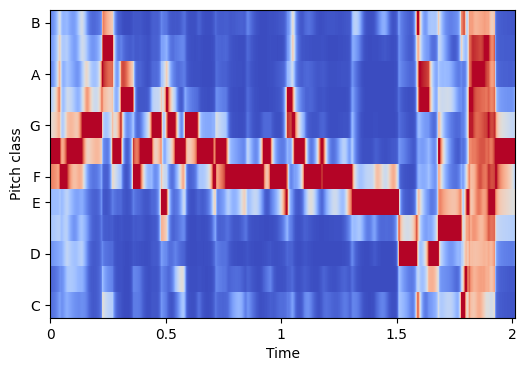

In [ ]:
hop_length=12
chromagram = librosa.feature.chroma_stft(y=sample_audio,
                                         sr=sample_sr,
                                         hop_length=hop_length)
plt.figure(figsize=(6, 4))
librosa.display.specshow(chromagram,
                         x_axis='time',
                         y_axis='chroma',
                         hop_length=hop_length,
                         cmap='coolwarm')
plt.show()

# Split Train and Test set

In [ ]:
english_list = ['en-AU', 'en-GB', 'en-US']
english_dataset = dataset.filter(
    lambda x: x if dataset.features['lang_id'].names[x['lang_id']] in english_list else None
)

len(english_dataset)

1809

In [ ]:
# train test split
english_dataset = english_dataset.train_test_split(test_size=0.1)
english_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 1628
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 181
    })
})

# Transcription - Pre Trained *Model*

In [ ]:
from transformers import (WhisperProcessor, WhisperForConditionalGeneration,
                          pipeline)
import time

In [ ]:
def run_transcription(model_name, data, language='en', batch_size=8):
    task = "automatic-speech-recognition"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    pipe = pipeline(
        task,
        model=model_name,
        generate_kwargs={'language': language, 'task': 'transcribe'},
        device=device,
        chunk_length_s=60
    )

    prediction = pipe(data, batch_size=batch_size)

    prediction_name = f"prediction-{model_name.split('/')[-1]}.pkl"
    with open(os.path.join(data_path, prediction_name), "wb") as fp:
        pickle.dump(prediction, fp)
    print(f"Successfully save {prediction_name}")

# Whisper Large V3

In [ ]:
start = time.time()
model_name = "openai/whisper-large-v3"
run_transcription(model_name=model_name,
                  data=english_dataset['test']['audio'])
end = time.time()

print(f"Finish in {(end - start) / 60} minutes")

# clean cache to clear memory
torch.cuda.empty_cache()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Wave2vec2 Base

In [ ]:
start = time.time()
model_name = "facebook/wav2vec2-base-960h"
run_transcription(model_name=model_name,
                  data=english_dataset['test']['audio'])
end = time.time()

print(f"Finish in {(end - start) / 60} minutes")

torch.cuda.empty_cache() # clean cache to clear memory

# Wav2vec2 Large

In [ ]:
start = time.time()
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
run_transcription(model_name=model_name,
                  data=english_dataset['test']['audio'])
end = time.time()

print(f"Finish in {(end - start) / 60} minutes")

# clean cache to clear memory
torch.cuda.empty_cache()

# Evaluation

In [ ]:
import jiwer

In [ ]:
def load_prediction_result(prediction_name):
    with open(os.path.join(data_path, f"{prediction_name}.pkl"), "rb") as fp:
        prediction_result = pickle.load(fp)
    return prediction_result

def run_evaluation(
        true_transcriptions, generated_transcriptions):
    if len(true_transcriptions) != len(generated_transcriptions):
        print("Length of true and generated transcriptions must be the same size")
        return

    transforms = jiwer.Compose(
        [
            jiwer.ExpandCommonEnglishContractions(),
            jiwer.RemoveEmptyStrings(),
            jiwer.ToLowerCase(),
            jiwer.RemoveMultipleSpaces(),
            jiwer.Strip(),
            jiwer.RemovePunctuation(),
            jiwer.ReduceToListOfListOfWords(),
        ]
    )
    total_wer, total_cer, error_sentences = 0, 0, 0
    for i in range(len(true_transcriptions)):
        total_wer += jiwer.wer(
            true_transcriptions[i],
            generated_transcriptions[i]['text'],
            truth_transform=transforms,
            hypothesis_transform=transforms,
        )
        total_cer += jiwer.cer(
            true_transcriptions[i],
            generated_transcriptions[i]['text'],
            truth_transform=transforms,
            hypothesis_transform=transforms
        )

        if true_transcriptions[i] != generated_transcriptions[i]['text']:
            error_sentences += 1


    avg_wer = total_wer / len(true_transcriptions)
    avg_acc = (1 - avg_wer) * 100

    avg_cer = total_cer / len(true_transcriptions)
    avg_ser = error_sentences / len(true_transcriptions)

    return avg_wer, avg_cer, avg_ser, avg_acc

In [ ]:
true_transcriptions = english_dataset['test']['transcription']

In [ ]:
# whisper v3 result
prediction_name = "prediction-whisper-large-v3"
prediction_whisper = load_prediction_result(prediction_name)

avg_wer, avg_cer, avg_ser, avg_acc = run_evaluation(
    true_transcriptions, prediction_whisper)
print(avg_wer, avg_cer, avg_ser, avg_acc)

In [ ]:
# wav2vec2 base result
prediction_name = "prediction-wav2vec2-base-960h"
prediction_wav2vec2_base = load_prediction_result(prediction_name)

avg_wer, avg_cer, avg_ser, avg_acc = run_evaluation(
    true_transcriptions, prediction_wav2vec2_base)
print(avg_wer, avg_cer, avg_ser, avg_acc)

In [ ]:
# wav2vec2 large result
prediction_name = "prediction-wav2vec2-large-xlsr-53-english"
prediction_wav2vec2_large = load_prediction_result(prediction_name)

avg_wer, avg_cer, avg_ser, avg_acc = run_evaluation(
    true_transcriptions, prediction_wav2vec2_large)
print(avg_wer, avg_cer, avg_ser, avg_acc)

In [ ]:
result_dict = dict(true=[], whisper=[], wav2vec2_base=[], wav2vec2_large=[])

for i in range(10):
    result_dict['true'].append(true_transcriptions[i])
    result_dict['whisper'].append(prediction_whisper[i]['text'])
    result_dict['wav2vec2_base'].append(prediction_wav2vec2_base[i]['text'])
    result_dict['wav2vec2_large'].append(prediction_wav2vec2_large[i]['text'])

result_df = pd.DataFrame(result_dict)
result_df.head()



The best pre trained models explored to run English transcription is the Whisper V3 large

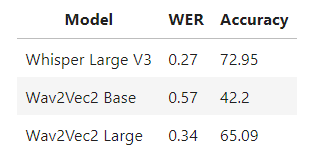